<a href="https://colab.research.google.com/github/MDfarazuddin99/CNN_Pruning/blob/master/HISTORICAL_CORRELATION_OF_L1_NORMSs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import load_model

In [72]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

def normalize(x_train,x_test):
    mean = np.mean(x_train,axis=(0,1,2,3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    x_train = (x_train-mean)/(std+1e-7)
    x_test = (x_test-mean)/(std+1e-7)
    return x_train, x_test
from keras.utils import np_utils
x_train , x_test = normalize(x_train,x_test)

y_train = np_utils.to_categorical(y_train,10)
y_test = np_utils.to_categorical(y_test,10)

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



model_1 = Sequential()

model_1.add(Conv2D(32,(3,3),activation='relu',input_shape=x_train.shape[1:]))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(32,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(64,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(10,activation='softmax'))

In [76]:
my_model = model_1
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)               

In [77]:
my_model = load_model('drive/My Drive/Colab Notebooks/model1_before_pruning.h5')
score_train = my_model.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1] * 100)

score_test = my_model.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1] * 100)

50000/50000 [==============================] - 3s 67us/step
Accuracy on the Train Images:  88.32600000000001
10000/10000 [==============================] - 1s 64us/step
Accuracy on the Test Images:  67.56


In [78]:
def my_get_all_conv_layers(model):
    all_conv_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:6] == 'conv2d'):
            all_conv_layers.append(i)
    return all_conv_layers

def my_get_all_dense_layers(model):
    all_dense_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:5] == 'dense'):
            all_dense_layers.append(i)
    return all_dense_layers


all_dense_layers = my_get_all_dense_layers(my_model)

all_conv_layers = my_get_all_conv_layers(my_model)

print('All convolution layers = ',all_conv_layers,'\nAll dense layers = ',all_dense_layers)


All convolution layers =  [0, 2, 4] 
All dense layers =  [7]


In [0]:
## incomplete  (didn't understood how to access weights )
layer_wise_weights_for_all_epochs = list()

def my_get_weights_in_conv_layers(model):
  # weights_dict = dict()
  weights = list()
  all_conv_layers = my_get_all_conv_layers(model)
  layer_wise_weights = list() 
  for i in all_conv_layers:
        weights.append(model.layers[i].get_weights()[0])  
  return weights




In [80]:
x = (my_get_weights_in_conv_layers(my_model))
print('shapes of weight Tensors in convolutional layers are')
for i in x:
    print(i.shape)

shapes of weight Tensors in convolutional layers are
(3, 3, 3, 32)
(3, 3, 32, 32)
(3, 3, 32, 64)


In [81]:
my_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
my_model.fit(x_train, y_train, batch_size=32, epochs=2, verbose=1, validation_split=0.2, shuffle=True  )
my_model.save('drive/My Drive/Colab Notebooks/model1_before_pruning.h5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 8s 193us/step - loss: 0.1653 - acc: 0.9400 - val_loss: 2.3790 - val_acc: 0.6793
Epoch 2/2
40000/40000 [==============================] - 7s 178us/step - loss: 0.1549 - acc: 0.9439 - val_loss: 2.3663 - val_acc: 0.6817


In [0]:
from keras.callbacks import Callback
class Get_Weights(Callback):
    def __init__(self):
        super(Get_Weights, self).__init__()
        self.weight_list = [] #Using a list of list to store weight tensors per epoch

    def on_epoch_end(self,epoch,logs=None):
        if epoch ==0:
            all_conv_layers = my_get_all_conv_layers(self.model)
            for i in range(len(all_conv_layers)):
                self.weight_list.append([]) # appending empty lists for later appending weight tensors 
        
        for index,each_weight in enumerate(my_get_weights_in_conv_layers(self.model)):
                self.weight_list[index].append(each_weight)  
    



In [83]:
 my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

In [84]:
gw = Get_Weights()

my_model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2, shuffle=True , callbacks= [gw] )


Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 7s 176us/step - loss: 0.1567 - acc: 0.9424 - val_loss: 2.4662 - val_acc: 0.6774
Epoch 2/10
40000/40000 [==============================] - 7s 173us/step - loss: 0.1549 - acc: 0.9443 - val_loss: 2.4676 - val_acc: 0.6771
Epoch 3/10
40000/40000 [==============================] - 7s 179us/step - loss: 0.1535 - acc: 0.9443 - val_loss: 2.4927 - val_acc: 0.6757
Epoch 4/10
40000/40000 [==============================] - 7s 181us/step - loss: 0.1432 - acc: 0.9479 - val_loss: 2.4891 - val_acc: 0.6776
Epoch 5/10
40000/40000 [==============================] - 7s 175us/step - loss: 0.1556 - acc: 0.9432 - val_loss: 2.4350 - val_acc: 0.6765
Epoch 6/10
40000/40000 [==============================] - 7s 177us/step - loss: 0.1487 - acc: 0.9466 - val_loss: 2.4500 - val_acc: 0.6772
Epoch 7/10
40000/40000 [==============================] - 7s 176us/step - loss: 0.1494 - acc: 0.9468 - val_loss: 2.5111 - 

(10, 3, 3, 3, 32)
(10, 3, 3, 32, 32)
(10, 3, 3, 32, 64)
shapes of a b c are  (10, 27, 32) (10, 288, 32) (10, 288, 64)
(32, 10)


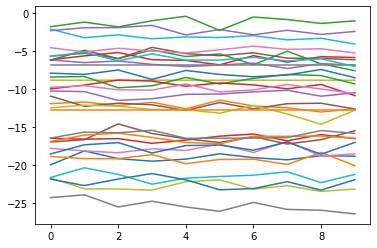

In [103]:
for we in gw.weight_list:
    print(np.array(we).shape)
weight_list_per_epoch = gw.weight_list
a = np.array(weight_list_per_epoch[0]).reshape(10,3*3*3,-1)
b = np.array(weight_list_per_epoch[1]).reshape(10,3*3*32,-1)
c = np.array(weight_list_per_epoch[2]).reshape(10,3*3*32,-1)
print("shapes of a b c are ",a.shape,b.shape,c.shape)
# print(a[0])
x1 = np.sum(b,axis = 1)

x1 = x1.T
print(x1.shape)


for i in range(x1.shape[0]):
    plt.plot(np.arange(10),x1[i])
# plt.plot(np.arange(10),x1[1])
# plt.plot(np.arange(10),x1[2])
# plt.plot(np.arange(10),x1[3])

#  the above variable (weight_list_per_epoch) should be stord in some csv/h5 file.

In [0]:
def my_in_conv_layer_get_l1_norms_per_epoch(weight_list_per_epoch):
    l1_norm_list_per_epoch = list()
    for i in range(len(weight_list_per_epoch)):
        l1_norm_list_per_epoch.append([]) 
    for layer_index in range(len(weight_list_per_epoch)):
        l1_norm_
        


In [0]:
### correlation
from scipy.stats import pearsonr
corr, _ = pearsonr(list1, list2)